# Project: Breast Cancer classification

# Step 1

Libraries

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn

# Step 2

Database

In [7]:
# experiment reproducibility
np.random.seed(123)
torch.manual_seed(123)

In [8]:
forecasters = pd.read_csv('/content/entradas_breast.csv') # features
label = pd.read_csv('/content/saidas_breast.csv') # binary classification

In [9]:
forecasters.shape

(569, 30)

In [10]:
forecasters.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [11]:
label.head()

,0
0,0
1,0
2,0
3,0
4,0


In [12]:
np.unique(label)

array([0, 1])

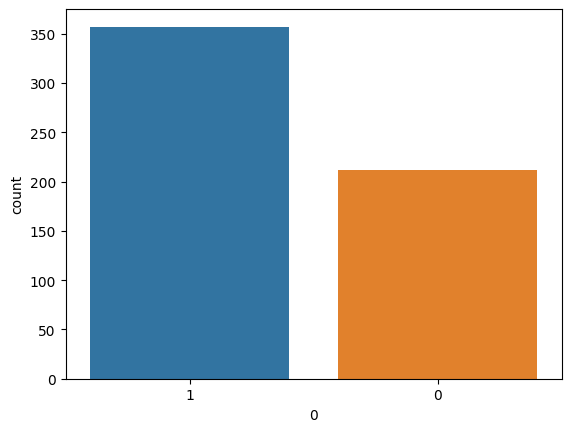

In [18]:
true_label = label[label['0'] == 1]
false_label = label[label['0'] == 0]

sns.countplot(data=true_label, x='0')
sns.countplot(data=false_label, x='0');

In [67]:
forecasters_train, forecasters_test, label_train, label_test = train_test_split(forecasters, label, test_size=0.25)

In [20]:
forecasters_train.shape

(426, 30)

In [21]:
label_train.shape

(426, 1)

In [22]:
forecasters_test.shape

(143, 30)

In [23]:
label_test.shape

(143, 1)

# Step 3

The transformation of data into tensors.


In [24]:
type(forecasters_train)

pandas.core.frame.DataFrame

In [25]:
type(np.array(forecasters_train))

numpy.ndarray

tensor is like array, but they are transformed to guarantee a processing in gpu

In [28]:
forecasters_train = torch.tensor(np.array(forecasters_train), dtype=torch.float)
label_train = torch.tensor(np.array(label_train), dtype=torch.float)

In [29]:
type(forecasters_train)

torch.Tensor

In [30]:
type(label_train)

torch.Tensor

In [33]:
dataset = torch.utils.data.TensorDataset(forecasters_train, label_train)

In [34]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [35]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

# Step 4

Model building

In [36]:
# 30 -> input layer
# 2 -> hidden layer (16 neurons, 16 neurons)
# 1 -> output layer (binary classification)
# (input + output) / 2 -> number of neurons in hidden layer
# in_features -> number of neurons in input layer
# out features -> number of neurons coneccted in hidden layer

classifier = nn.Sequential(
    nn.Linear(in_features=30, out_features=16), # dense -> all input layer conect to each other hidden layer
    nn.ReLU(), # ReLU function will be applied to all neurons in hidden layer
    nn.Linear(16, 16), # number of neurons linked
    nn.ReLU(),
    nn.Linear(16, 1), # number of neurons linked to hidden layer, output layer
    nn.Sigmoid() # returns an probability
)

In [41]:
classifier.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [39]:
criterion = nn.BCELoss() # error function

In [43]:
# lr -> learning rate
# weigth_decay -> help algorithm to reach minimum global

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001,weight_decay=0.0001 )

# Step 5

Model train

In [49]:
# requieres an manual "fit"
# 426 features in forecaster; batch_size = 10; approximately 42,6 weigth adjust
# in each epoch we will pass in 426 features, but the features are divided in 10 by 10
for epoch in range(100):
  running_loss = 0.

  for data in train_loader:
    inputs, labels = data
    optimizer.zero_grad() # after weigth adjust an new calculus are required

    outputs = classifier(inputs) # classifier.foward(inputs)

    loss = criterion(outputs, labels)

    # backpropagation
    loss.backward()

    # weight adjust
    optimizer.step()

    running_loss += loss.item()

  print('Epoch %3d: loss %.5f' % (epoch+1, running_loss/len(train_loader)))


Epoch   1: loss 0.12758
Epoch   2: loss 0.13959
Epoch   3: loss 0.09847
Epoch   4: loss 0.13449
Epoch   5: loss 0.09817
Epoch   6: loss 0.12177
Epoch   7: loss 0.12399
Epoch   8: loss 0.14151
Epoch   9: loss 0.11614
Epoch  10: loss 0.09435
Epoch  11: loss 0.07151
Epoch  12: loss 0.07629
Epoch  13: loss 0.07562
Epoch  14: loss 0.08622
Epoch  15: loss 0.10947
Epoch  16: loss 0.08115
Epoch  17: loss 0.10428
Epoch  18: loss 0.08879
Epoch  19: loss 0.08800
Epoch  20: loss 0.07089
Epoch  21: loss 0.07242
Epoch  22: loss 0.08038
Epoch  23: loss 0.08496
Epoch  24: loss 0.08692
Epoch  25: loss 0.07474
Epoch  26: loss 0.07831
Epoch  27: loss 0.06953
Epoch  28: loss 0.07745
Epoch  29: loss 0.08709
Epoch  30: loss 0.06379
Epoch  31: loss 0.07993
Epoch  32: loss 0.06652
Epoch  33: loss 0.08906
Epoch  34: loss 0.09040
Epoch  35: loss 0.08519
Epoch  36: loss 0.14859
Epoch  37: loss 0.10712
Epoch  38: loss 0.10659
Epoch  39: loss 0.07789
Epoch  40: loss 0.08892
Epoch  41: loss 0.07607
Epoch  42: loss 

# Step 6

Weight view

In [50]:
params = list(classifier.parameters())

In [51]:
params

[Parameter containing:
 tensor([[-1.6570e-01, -2.4836e-01, -1.8314e-01,  7.0553e-02, -8.0485e-03,
           3.4087e-02,  5.7071e-02,  2.0878e-02, -2.0968e-01,  4.9149e-01,
           3.8768e-01, -2.0574e-02, -1.2182e-01, -4.1697e-02,  3.9601e-03,
          -1.4010e-01,  4.5264e-02, -1.1658e-02,  6.7057e-02,  4.2223e-03,
           9.6112e-02, -2.7370e-01, -8.1983e-02,  1.3447e-01,  4.2228e-01,
           1.3651e-01,  1.4144e-03,  7.3753e-02,  5.3778e-01,  1.7543e-01],
         [ 2.9927e-01,  2.1022e-01,  4.5661e-01,  6.2403e-02, -7.2313e-01,
          -2.9361e-01, -9.4107e-02, -3.2463e-01, -2.2531e-03,  2.4662e-01,
          -9.4853e-03, -1.0876e-01,  1.0872e-02,  1.6764e-01, -1.7119e-02,
          -1.4561e-01, -1.6768e-01,  5.7358e-02,  2.1374e-02, -1.8283e-02,
           2.0710e-01, -4.8487e-02,  3.2825e-01, -3.5561e-02, -1.3504e-01,
          -2.1370e-01, -2.6028e-01, -1.4133e-01, -1.0080e-01, -1.5218e-01],
         [-2.7914e-02, -7.6200e-02, -3.0694e-01, -1.3082e-01, -8.9767e-04,


In [52]:
weight0 = params[0]
weight0.shape

torch.Size([16, 30])

In [53]:
print(weight0)

Parameter containing:
tensor([[-1.6570e-01, -2.4836e-01, -1.8314e-01,  7.0553e-02, -8.0485e-03,
          3.4087e-02,  5.7071e-02,  2.0878e-02, -2.0968e-01,  4.9149e-01,
          3.8768e-01, -2.0574e-02, -1.2182e-01, -4.1697e-02,  3.9601e-03,
         -1.4010e-01,  4.5264e-02, -1.1658e-02,  6.7057e-02,  4.2223e-03,
          9.6112e-02, -2.7370e-01, -8.1983e-02,  1.3447e-01,  4.2228e-01,
          1.3651e-01,  1.4144e-03,  7.3753e-02,  5.3778e-01,  1.7543e-01],
        [ 2.9927e-01,  2.1022e-01,  4.5661e-01,  6.2403e-02, -7.2313e-01,
         -2.9361e-01, -9.4107e-02, -3.2463e-01, -2.2531e-03,  2.4662e-01,
         -9.4853e-03, -1.0876e-01,  1.0872e-02,  1.6764e-01, -1.7119e-02,
         -1.4561e-01, -1.6768e-01,  5.7358e-02,  2.1374e-02, -1.8283e-02,
          2.0710e-01, -4.8487e-02,  3.2825e-01, -3.5561e-02, -1.3504e-01,
         -2.1370e-01, -2.6028e-01, -1.4133e-01, -1.0080e-01, -1.5218e-01],
        [-2.7914e-02, -7.6200e-02, -3.0694e-01, -1.3082e-01, -8.9767e-04,
          1.94

In [56]:
bias0 = params[1]
bias0.shape

torch.Size([16])

In [58]:
weight1 = params[2]
weight1.shape

torch.Size([16, 16])

In [59]:
bias1 = params[3]
bias1.shape

torch.Size([16])

# Step 7

Model evaluation

In [60]:
classifier.eval() # active evaluete model. Its necessary, otherwise the model will only train

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [68]:
type(forecasters_test)

pandas.core.frame.DataFrame

In [69]:
forecasters_test = torch.tensor(np.array(forecasters_test), dtype=torch.float)

In [70]:
type(forecasters_test)

torch.Tensor

In [71]:
forecaster = classifier.forward(forecasters_test)

In [72]:
forecaster

tensor([[9.9997e-01],
        [9.9999e-01],
        [9.9965e-01],
        [5.8461e-04],
        [3.9003e-07],
        [1.0000e+00],
        [9.9781e-01],
        [1.0000e+00],
        [9.9093e-01],
        [8.0025e-01],
        [1.0731e-18],
        [1.0000e+00],
        [2.7253e-01],
        [9.9999e-01],
        [1.0000e+00],
        [1.0000e+00],
        [9.9848e-01],
        [9.9999e-01],
        [8.5663e-09],
        [1.0000e+00],
        [1.0000e+00],
        [9.9404e-01],
        [1.0000e+00],
        [5.6757e-02],
        [9.9995e-01],
        [9.7133e-01],
        [1.0000e+00],
        [3.3823e-06],
        [9.7332e-01],
        [9.9952e-01],
        [3.7166e-01],
        [1.8819e-05],
        [1.4968e-02],
        [1.1428e-14],
        [4.6282e-05],
        [1.0179e-04],
        [1.0000e+00],
        [3.9773e-02],
        [9.9964e-01],
        [5.4352e-01],
        [7.4911e-04],
        [8.7034e-02],
        [5.4727e-10],
        [9.9941e-01],
        [1.0000e+00],
        [0

In [73]:
forecaster = np.array(forecaster > 0.5)

In [74]:
forecaster

array([[ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [

In [75]:
accuracy_rate = accuracy_score(label_test, forecaster )

In [76]:
accuracy_rate

0.951048951048951

In [77]:
matrix = confusion_matrix(label_test, forecaster)

In [78]:
matrix

array([[51,  3],
       [ 4, 85]])

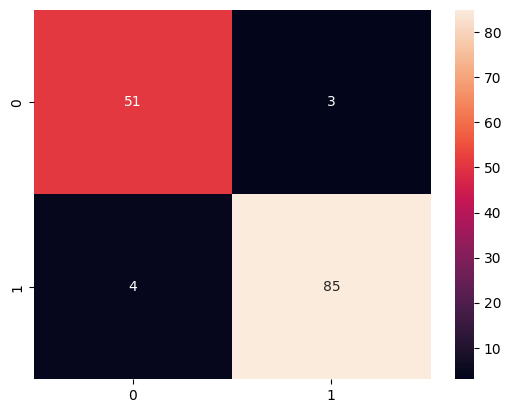

In [80]:
sns.heatmap(matrix, annot=True);